In [1]:
from preprocess_data import *
from TDApipeline import *
from intensities_pipeline import *
from knn_pipeline import *
import scipy.io as sio
import os
import time  
import matplotlib.pyplot as plt
import pandas as pd
import numpy.linalg as la
import numpy as np

def define_subject_dir(i_sub):
    """
    Creates the directory if it doesn't exist
    :param i_sub: subject id
    :return: directory path
    """
    res_dir = "results/intensities/subject_" + str(i_sub) +'/'
    if not os.path.exists(res_dir):
        print("create directory:", res_dir)
        os.makedirs(res_dir)
    return res_dir

def load_data(i_sub,space='both'):
    """
    Loads data from electrode space, font space 
    or both for a given subject
    :param i_sub: subject id
    :param space: electrode/font_space
    :return: data,directory path
    """
    subj_dir = define_subject_dir(i_sub)
    raw_data = sio.loadmat('data/dataClean-ICA3-'+str(i_sub)+'-T1.mat')
    
    if space=='electrodeSpace':
        elec_space=raw_data['dataSorted'] # [N,T,n_trials,motiv] 
        return elec_space,subj_dir
    elif space=='fontSpace':
        font_space=raw_data['ic_data3']
        return font_space,subj_dir
    else:
        elec_space=raw_data['dataSorted'] # [N,T,n_trials,motiv] 
        font_space=raw_data['ic_data3']
        return (elec_space,font_space),subj_dir,raw_data['indexM']

In [7]:
s,subj_dir=load_data(25,space='electrodeSpace')

In [4]:
electrodes_pos = np.load('results/intensities/xy_coord.npy')


In [5]:
electr_coord = pd.DataFrame(np.array([electrodes_pos[:, -1],
                                              electrodes_pos[:, 1].astype(float),
                                              electrodes_pos[:, 2].astype(float)]).T)


In [8]:
subj_dir

'results/intensities/subject_25/'

results/intensities/subject_25/electrodeSpace/alpha/session0/reprojected_means_m0.npy
results/intensities/subject_25/electrodeSpace/alpha/session1/reprojected_means_m0.npy
results/intensities/subject_25/electrodeSpace/alpha/session0/reprojected_means_m0.npy
results/intensities/subject_25/electrodeSpace/alpha/session1/reprojected_means_m0.npy
results/intensities/subject_25/electrodeSpace/alpha/session0/reprojected_means_m0.npy
results/intensities/subject_25/electrodeSpace/alpha/session1/reprojected_means_m0.npy
results/intensities/subject_25/electrodeSpace/alpha/session0/reprojected_means_m0.npy
results/intensities/subject_25/electrodeSpace/alpha/session1/reprojected_means_m0.npy
results/intensities/subject_25/electrodeSpace/beta/session0/reprojected_means_m0.npy
results/intensities/subject_25/electrodeSpace/beta/session1/reprojected_means_m0.npy
results/intensities/subject_25/electrodeSpace/beta/session0/reprojected_means_m0.npy
results/intensities/subject_25/electrodeSpace/beta/sessio

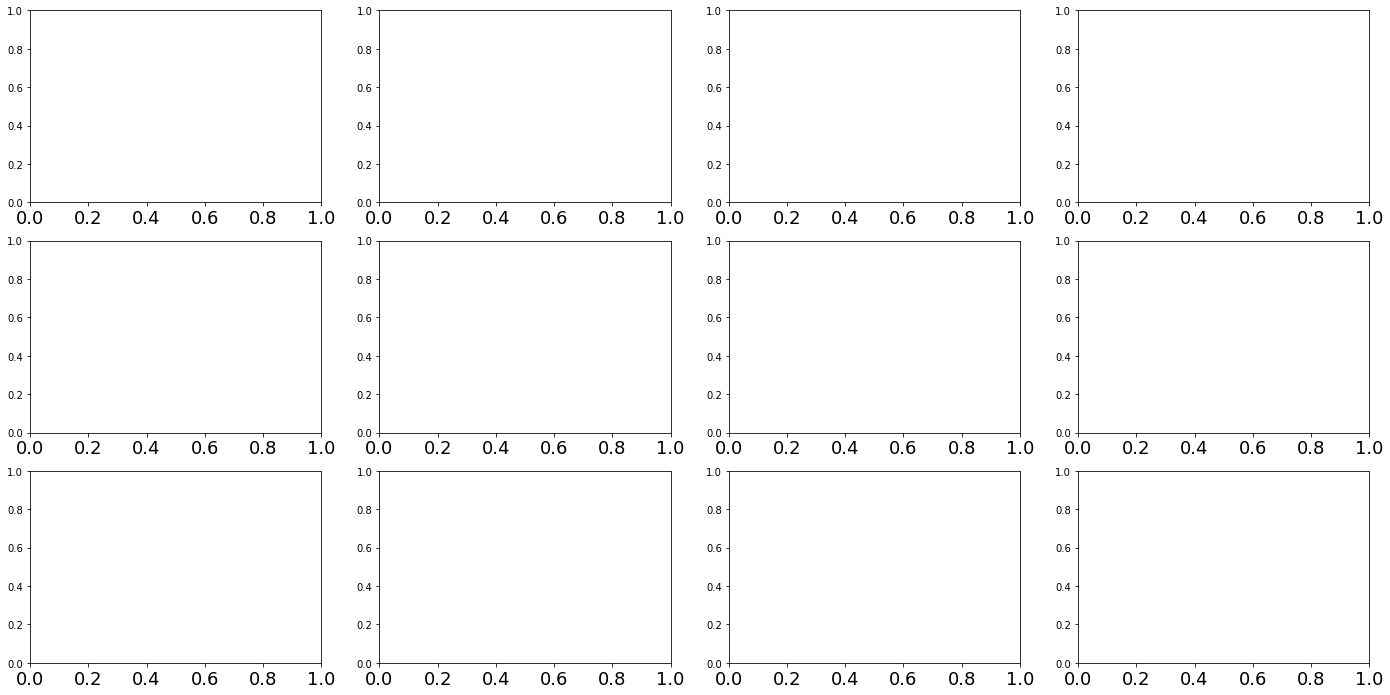

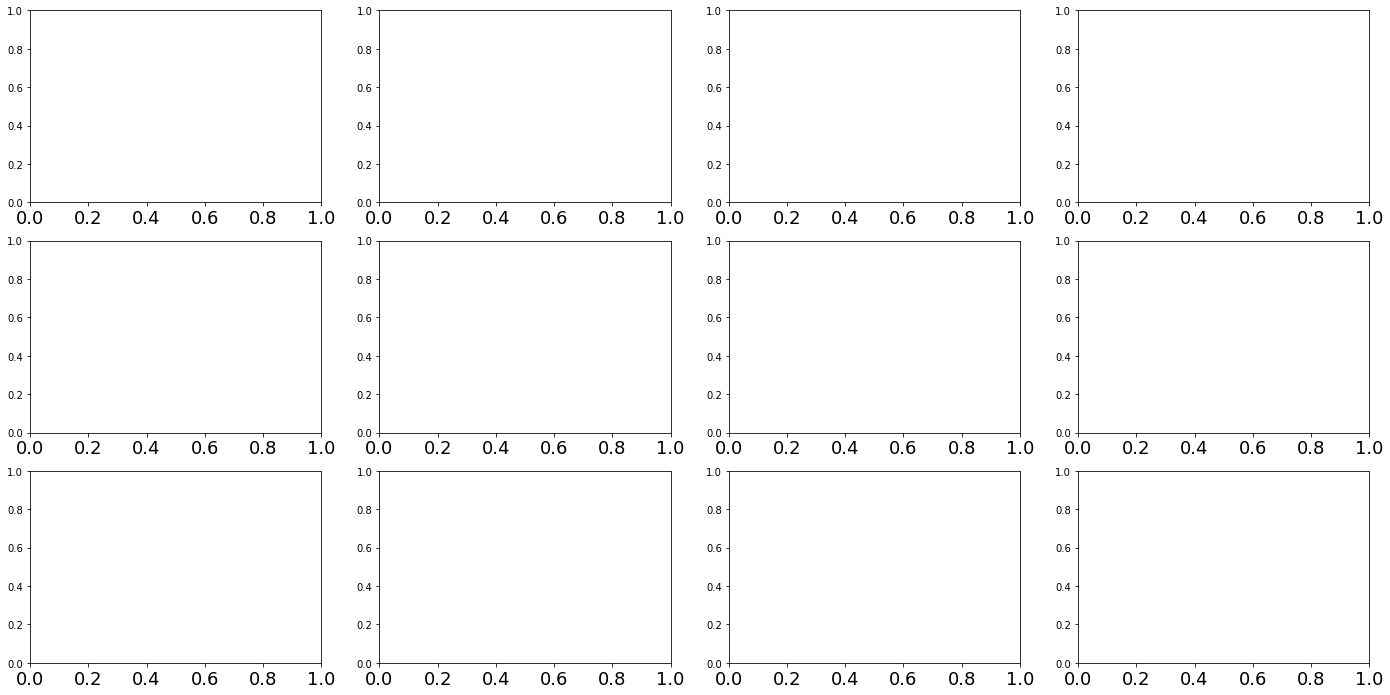

In [10]:
subjects=list(range(25,26)) 
bands=[-1,0,1,2] 
sessions=list(range(1,3))
spaces=['electrodeSpace','fontSpace']
band_dic={-1: 'noFilter', 0:'alpha',1:'beta',2:'gamma'} 
for subj in subjects:
    silent_chan = np.load('results/intensities/subject_'+str(subj)+'/silent-channels-'+str(subj)+'.npy')
    electr_coord['is_silent'] = silent_chan
    electr_coord.columns = ['electrode_name', 'x', 'y', 'is_silent']
    for space in spaces:
        fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(24, 12))
        plt.rcParams['xtick.labelsize']=18
        for i_band in range(3):
            for j in range(4):
                for ses in range(2):
                    print(np.load(subj_dir+space+'/'+band_dic[i_band]+'/session'+str(ses)+'/reprojected_means_m'+str(i)+'.npy').shape)
                